# Import Dependencies

In [1]:
import warnings                                  # `do not disturb`
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
import pickle
%matplotlib inline

In [2]:
# For bitcoin only

In [3]:
with open("./data/btc.pickle", 'rb') as f:
    btc = pickle.load(f)

In [4]:
btc.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


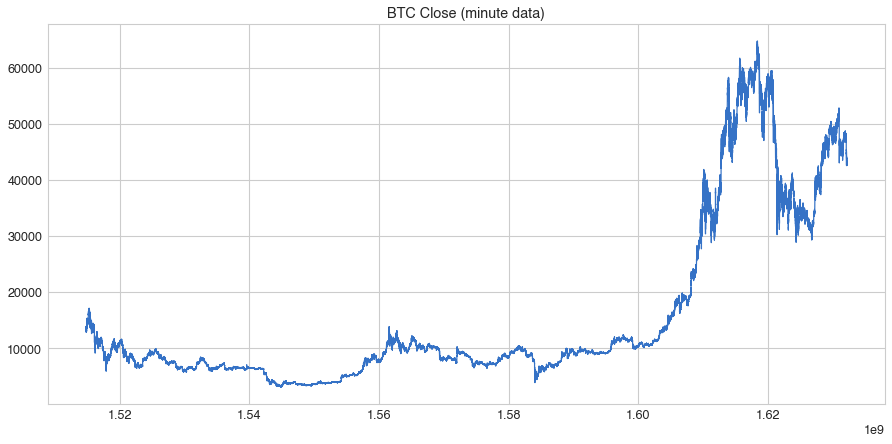

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(btc.Close)
plt.title('BTC Close (minute data)')
plt.grid(True)
plt.show()

# Forecast Quality Metrics

Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

In [6]:
# Importing metrics

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Move, smoothe, evaluate

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the **moving average**.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [7]:
def moving_average(series, n=15):
    """
    Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(btc.Close, 15) # prediction for the last observed day (past 24 hours)

42700.40728489211

Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [8]:
# Before moving forward, let's create a shorter version of our dataset so it's easily visible
btc_mini = btc.copy()
btc_mini = btc_mini.iloc[-700:,:]

In [9]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    
    """
        df - dataframe with timeseries
        column_name - name of column to analyze (choose 1 at a time)
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """

    rolling_mean = btc_mini.Target.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "red", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(
            series[window:], rolling_mean[window:]
        )
        
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bound, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, name=series.name)
            anomalies[series<lower_bound] = series[series<lower_bound]
            anomalies[series>upper_bound] = series[series>upper_bound]
            plt.plot(anomalies, "ro", markersize=10)
            
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(b=True)

In [ ]:
# 5-step trend
plotMovingAverage(btc_mini.Target, window=5)

In [ ]:
# 10-step trend
plotMovingAverage(btc_mini.Target, window=10) 

In [ ]:
# 15-step trend
plotMovingAverage(btc_mini.Target, window=15) 

In [ ]:
# 30-step trend
plotMovingAverage(btc_mini.Target, window=30)

In [ ]:
# 60-step trend
plotMovingAverage(btc_mini.Target, window=60)

In [ ]:
# 120-step trend
plotMovingAverage(btc_mini.Target, window=120)

Now, let's create a simple anomaly detection system with the help of moving average. 

In [ ]:
plotMovingAverage(btc_mini.Target, window=5, plot_intervals=True, plot_anomalies=True)

In [ ]:
plotMovingAverage(btc_mini.Target, window=10, plot_intervals=True, plot_anomalies=True)

In [ ]:
plotMovingAverage(btc_mini.Target, window=15, plot_intervals=True, plot_anomalies=True)

In [ ]:
plotMovingAverage(btc_mini.Target, window=30, plot_intervals=True, plot_anomalies=True)

In [ ]:
plotMovingAverage(btc_mini.Target, window=60, plot_intervals=True, plot_anomalies=True)

In [ ]:
plotMovingAverage(btc_mini.Target, window=120, plot_intervals=True, plot_anomalies=True)

Looks like it does a decent job of detecting anomalies

**Weighted average** is a simple modification to the moving average. The weights sum up to `1` with larger weights assigned to more recent observations.


$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [10]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [11]:
weighted_average(btc.Target, [0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05])

0.0059290540323613

# Exponential Smoothing

Now, let's see what happens if, instead of weighting the last $k$ values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for **[exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)** that will help us with this:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [12]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series.iloc[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series.iloc[n] + (1 - alpha) * result[n-1])
    return result

In [13]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

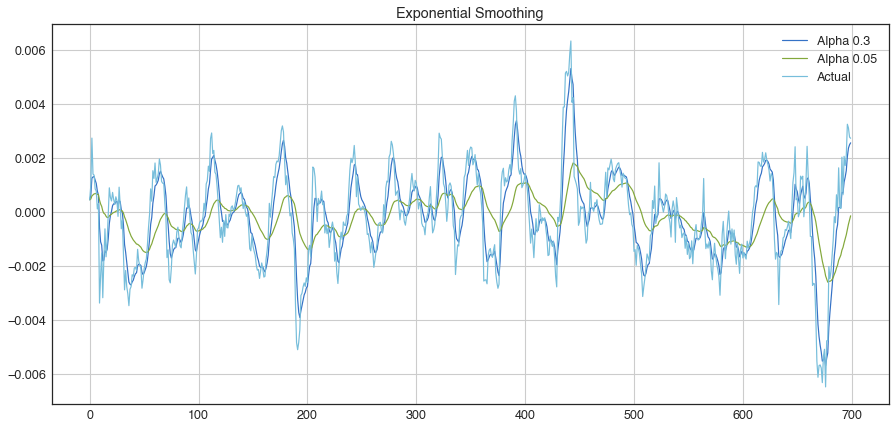

In [14]:
plotExponentialSmoothing(btc_mini.Target, [0.3, 0.05])

In [ ]:
plotExponentialSmoothing(btc_mini.Close, [0.3, 0.05])

# Double exponential smoothing

Up to now, the methods that we've discussed have been for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).

Series decomposition will help us -- we obtain two components: intercept (i.e. level) $\ell$ and slope (i.e. trend) $b$. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the $\beta$ coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [15]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series.iloc[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series.iloc[0], series.iloc[1] - series.iloc[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series.iloc[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

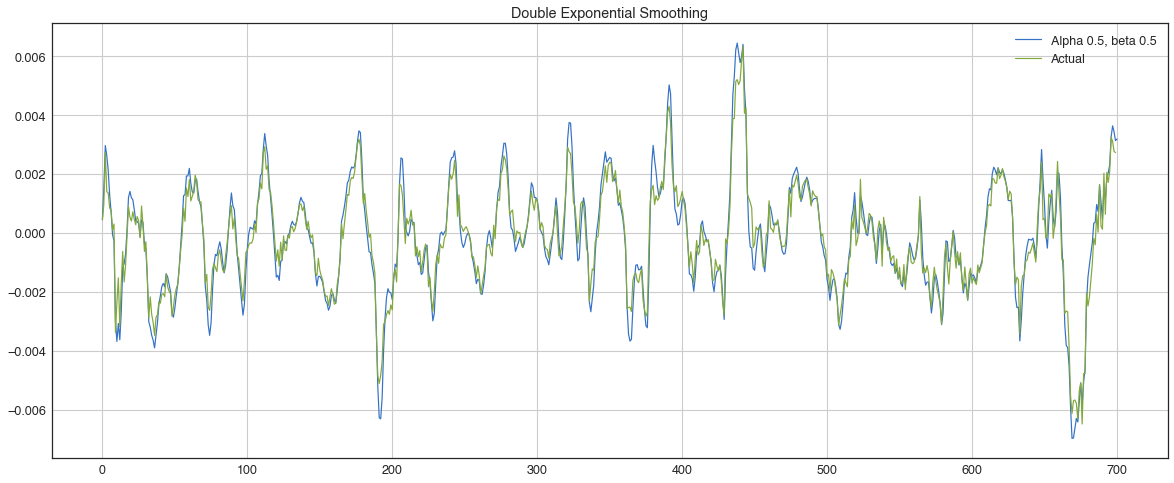

In [16]:
plotDoubleExponentialSmoothing(btc_mini.Target, alphas=[0.5], betas=[0.5])

Now we have to tune two parameters: $\alpha$ and $\beta$. The former is responsible for the series smoothing around the trend, the latter for the smoothing of the trend itself. The larger the values, the more weight the most recent observations will have and the less smoothed the model series will be. Certain combinations of the parameters may produce strange results, especially if set manually. We'll look into choosing parameters automatically in a bit; before that, let's discuss triple exponential smoothing.

# Triple exponential smoothing a.k.a. Holt-Winters

We've looked at exponential smoothing and double exponential smoothing. This time, we're going into _triple_ exponential smoothing.

As you could have guessed, the idea is to add a third component - seasonality. This means that we should not use this method if our time series is not expected to have seasonality. Seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words by the period after which the variations repeat. For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week.

With this, let's write out a new system of equations:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

The intercept now depends on the current value of the series minus any corresponding seasonal component. Trend remains unchanged, and the seasonal component depends on the current value of the series minus the intercept and on the previous value of the component. Take into account that the component is smoothed through all the available seasons; for example, if we have a Monday component, then it will only be averaged with other Mondays. You can read more on how averaging works and how the initial approximation of the trend and seasonal components is done [here](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Now that we have the seasonal component, we can predict not just one or two steps ahead but an arbitrary $m$ future steps ahead, which is very encouraging.

Below is the code for a triple exponential smoothing model, which is also known by the last names of its creators, Charles Holt and his student Peter Winters. Additionally, the Brutlag method was included in the model to produce confidence intervals:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T},$$

where $T$ is the length of the season, $d$ is the predicted deviation. Other parameters were taken from triple exponential smoothing. You can read more about the method and its applicability to anomaly detection in time series [here](http://fedcsis.org/proceedings/2012/pliks/118.pdf).

In [17]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   
  
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

## Time series cross validation

Before we start building a model, let's first discuss how to estimate model parameters automatically.

There is nothing unusual here; as always, we have to choose a loss function suitable for the task that will tell us how closely the model approximates the data. Then, using cross-validation, we will evaluate our chosen loss function for the given model parameters, calculate the gradient, adjust the model parameters, and so on, eventually descending to the global minimum.

You may be asking how to do cross-validation for time series because time series have this temporal structure and one cannot randomly mix values in a fold while preserving this structure. With randomization, all time dependencies between observations will be lost. This is why we will have to use a more tricky approach in optimizing the model parameters. I don't know if there's an official name to this, but on [CrossValidated](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection), where one can find all answers but the Answer to the Ultimate Question of Life, the Universe, and Everything, the proposed name for this method is "cross-validation on a rolling basis".

The idea is rather simple -- we train our model on a small segment of the time series from the beginning until some $t$, make predictions for the next $t+n$ steps, and calculate an error. Then, we expand our training sample to $t+n$ value, make predictions from $t+n$ until $t+2*n$, and continue moving our test segment of the time series until we hit the last available observation. As a result, we have as many folds as $n$ will fit between the initial training sample and the last observation.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Now, knowing how to set up cross-validation, we can find the optimal parameters for the Holt-Winters model. Recall that we have daily seasonality in ads, hence the `slen=24` parameter.

In [18]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In the Holt-Winters model, as well as in the other models of exponential smoothing, there's a constraint on how large the smoothing parameters can be, each of them ranging from 0 to 1. Therefore, in order to minimize our loss function, we have to choose an algorithm that supports constraints on model parameters. In our case, we will use the truncated Newton conjugate gradient.

In [65]:
%%time

from sklearn.metrics import mean_squared_error

data = btc_mini.Target.reset_index(drop=True)[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0]

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data,
                    slen = 25, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50,
                    scaling_factor = 3
)

model.triple_exponential_smoothing()

0.027869434816163774 0.021739539436002264 0.0008119248170220805
CPU times: user 454 ms, sys: 9.75 ms, total: 463 ms
Wall time: 462 ms


In [66]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

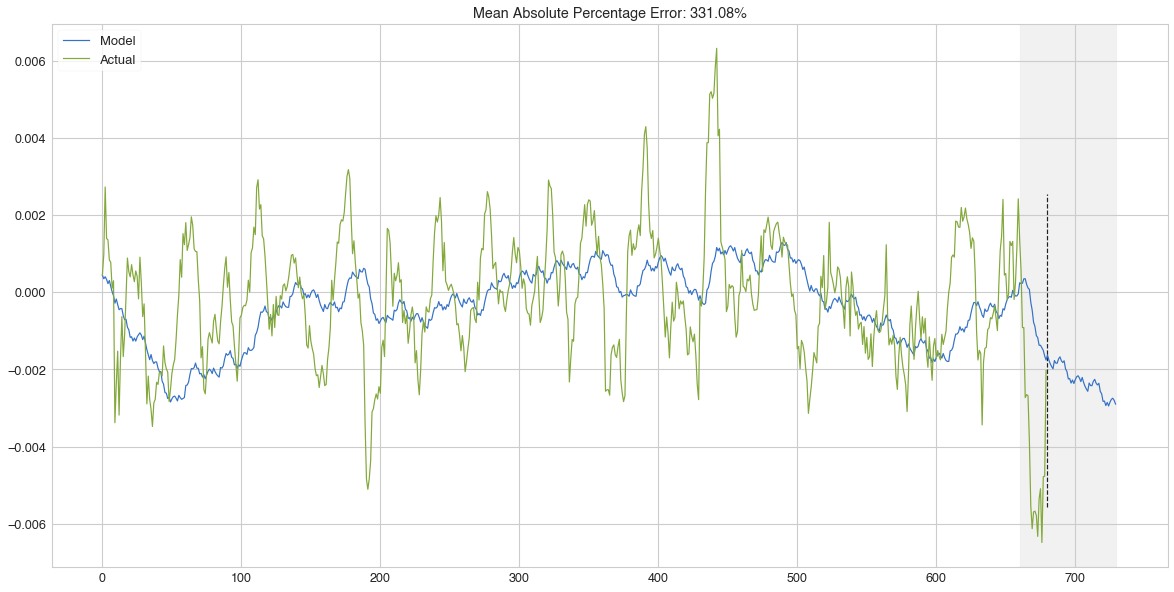

In [67]:
plotHoltWinters(btc_mini.Target[:-20])

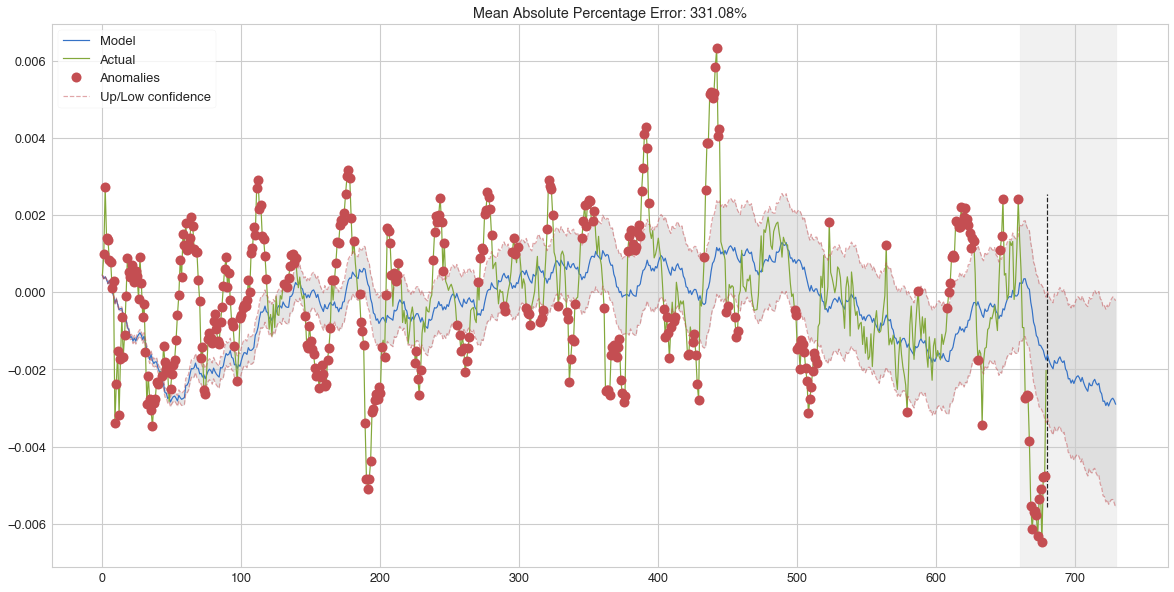

In [68]:
plotHoltWinters(data, plot_intervals=True, plot_anomalies=True)

# Try double-exponential smoothing with above analysis

Add a function in Holt-Winter class

# Econometric Approach

### Stationarity

Before we start modeling, we should mention such an important property of time series: [**stationarity**](https://en.wikipedia.org/wiki/Stationary_process).

If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called [homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity))The covariance function does not depend on time; it should only depend on the distance between observations. You can see this visually on the images in the post by [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- The red graph below is not stationary because the mean increases over time.

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- We were unlucky with the variance and see the varying spread of values over time

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice that the spread becomes closer as time increases. Hence, the covariance is not constant with time in the right chart.

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

So why is stationarity so important? Because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Furture predictions would be wrong if the original series were not stationary. Unfortunately, most of the time series that we see outside of textbooks are non-stationary, but we can (and should) change this.

So, in order to combat non-stationarity, we have to know our enemy, so to speak. Let's see how we can detect it. We will look at white noise and random walks to learn how to get from one to another for free.

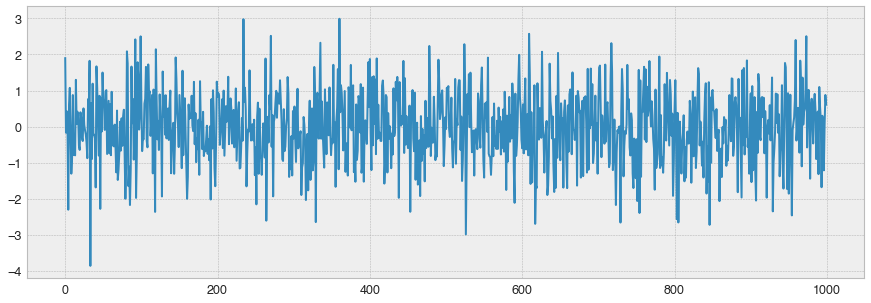

In [69]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

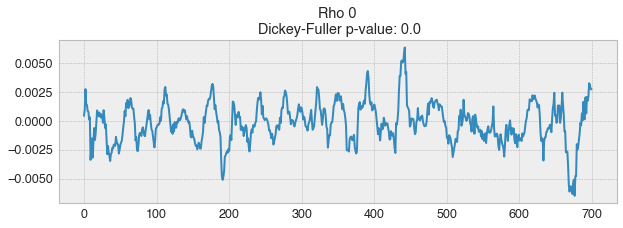

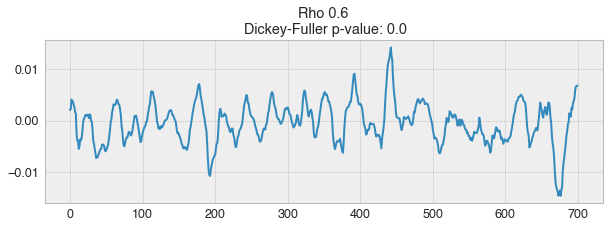

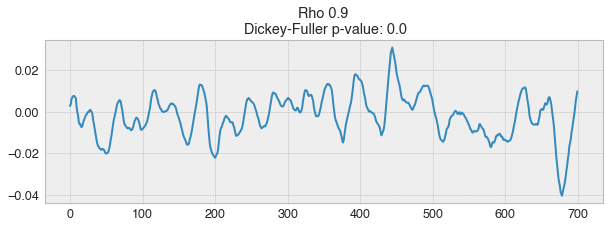

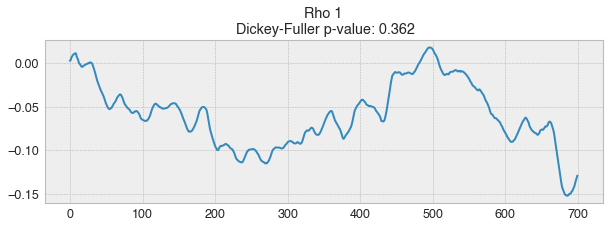

In [79]:
def plotProcess(n_samples=700, rho=0):
    # x = w = np.random.normal(size=n_samples)
    x = w = btc_mini.Target.reset_index(drop=True)
    for t in range(n_samples):
        x[t] = rho * x.iloc[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

On the first plot, you can see the same stationary white noise as before. On the second plot with $\rho$ increased to 0.6, wider cycles appeared, but it still appears stationary overall. The third plot deviates even more from the 0 mean but still oscillates about the mean. Finally, with $\rho=1$, we have a random walk process i.e. a non-stationary time series.

This happens because, after reaching the critical value, the series $x_t = \rho x_{t-1} + e_t$ does not return to its mean value. If we subtract $x_{t-1}$ from both sides, we will get $x_t - x_{t-1} = (\rho - 1) x_{t-1} + e_t$, where the expression on the left is referred to as the first difference. If $\rho=1$, then the first difference gives us stationary white noise $e_t$. This is the main idea behind the [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) for stationarity of time series (testing the presence of a unit root). If we can get a stationary series from a non-stationary series using the first difference, we call those series integrated of order 1. The null hypothesis of the test is that the time series is non-stationary, which was rejected on the first three plots and finally accepted on the last one. We have to say that the first difference is not always enough to get a stationary series as the process might be integrated of order d, d > 1 (and have multiple unit roots). In such cases, the augmented Dickey-Fuller test is used, which checks multiple lags at once.

We can fight non-stationarity using different approaches: various order differences, trend and seasonality removal, smoothing, and transformations like Box-Cox or logarithmic.

## Getting rid of non-stationarity and building SARIMA

Let's build an ARIMA model by walking through all the ~~circles of hell~~ stages of making a series stationary.

In [80]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

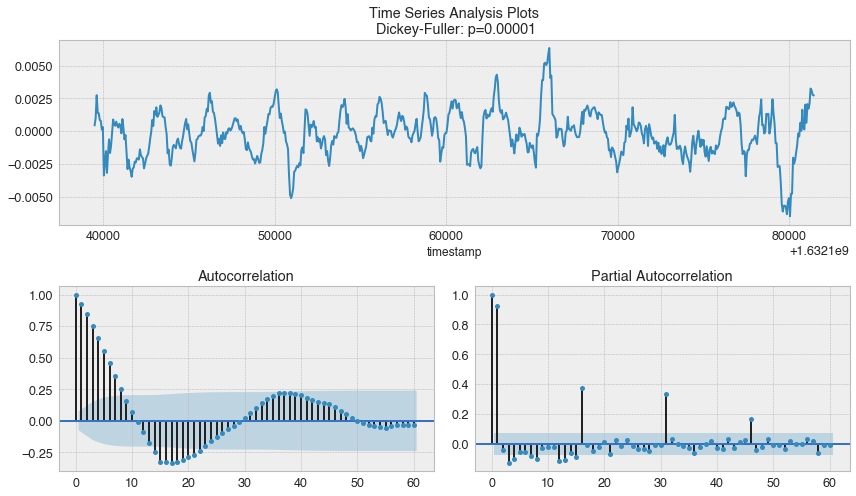

In [81]:
tsplot(btc_mini.Target, lags=60)

Surprisingly, the initial series are stationary; the Dickey-Fuller test rejected the null hypothesis that a unit root is present. Actually, we can see this on the plot itself -- we do not have a visible trend, so the mean is constant and the variance is pretty much stable. The only thing left is seasonality, which we have to deal with prior to modeling. To do so, let's take the "seasonal difference", which means a simple subtraction of the series from itself with a lag that equals the seasonal period.

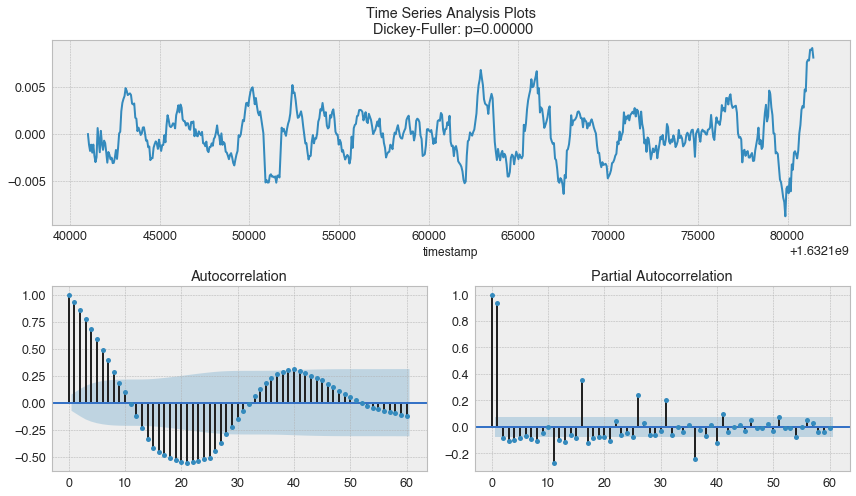

In [86]:
btc_mini_diff = btc_mini.Target - btc_mini.Target.shift(25)
tsplot(btc_mini_diff[25:], lags=60)

It is now much better with the visible seasonality gone. However, the autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1.

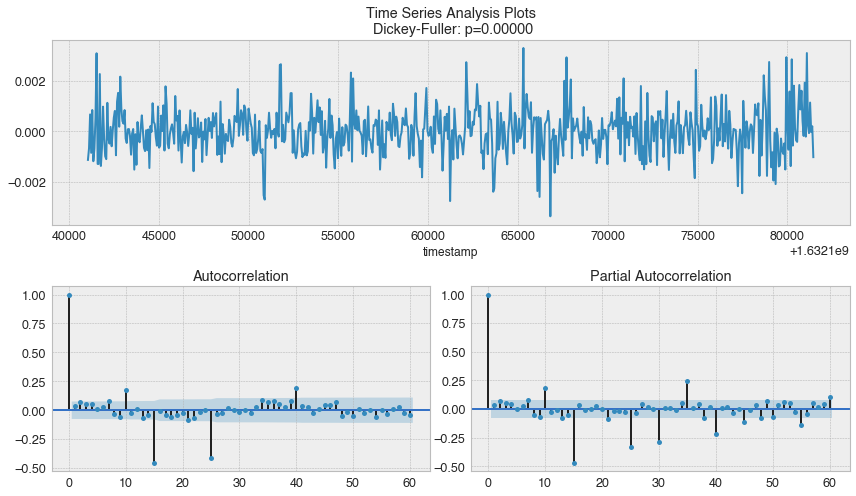

In [87]:
btc_mini_diff = btc_mini_diff - btc_mini_diff.shift(1)
tsplot(btc_mini_diff[25+1:], lags=60)

Perfect! Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. We can finally start modeling!

## ARIMA-family Crash-Course

We will explain this model by building up letter by letter. $SARIMA(p, d, q)(P, D, Q, s)$, Seasonal Autoregression Moving Average model:

- $AR(p)$ - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as $p$. To determine the initial $p$, you need to look at the PACF plot and find the biggest significant lag after which **most** other lags become insignificant.
- $MA(q)$ - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as $q$. The initial value can be found on the ACF plot with the same logic as before. 

Let's combine our first 4 letters:

$AR(p) + MA(q) = ARMA(p, q)$

What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

- $I(d)$ - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences. 

Adding this letter to the four gives us the $ARIMA$ model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

- $S(s)$ - this is responsible for seasonality and equals the season period length of the series

With this, we have three parameters: $(P, D, Q)$

- $P$ - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial $P$ should be 2.

- $Q$ - similar logic using the ACF plot instead.

- $D$ - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.